## Matrix Autoregression with Auxiliary Covariates (MARAC)

In [1]:
import time
import math,random, copy, pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorly.tenalg import mode_dot
from scipy.special import sph_harm
from scipy.stats import multivariate_normal
from MARAC import *
from sim_data_gen import *

mpl.rc('image', cmap='Reds')

### Simulate Data

In [11]:
simP, simQ, simR = 1, 1, 121
AR, AC, ERR, data = simulate(
    T=5000,
    M=10,
    N=10,
    R=simR,
    P=simP,  
    Q=simQ,
    random_state=42,
    auxiliary_multiplier=1.0, # controls the norm of G
    basis_gen_method="GP"
)

### Fit MARAC

In [12]:
# train/test data
train_T = 4000 # training data sample size
train_X, train_Z = data["Matrix-TS"][0:train_T], data["Vector-TS"][0:train_T]
test_X, test_Z = data["Matrix-TS"][train_T:], data["Vector-TS"][train_T:]

# model fitting
fitP, fitQ, fitR = 1, 1, 121
model = MARAC(
    P=fitP,
    Q=fitQ,
    R=fitR,
    method="PMLE"
)
model.fit(
    train_X, 
    train_Z, 
    KGram=AC["kernel_matrix"], 
    Basis=None, 
    BasisEigen=None, 
    max_iter=3000, 
    tol=1e-4, 
    lmbda=1e-3
)
model.reconstruct(None)

Y_pred_train = model.predict(train_X, train_Z, None)
Y_pred_test = model.predict(test_X, test_Z, None)

# compute RMSE
RMSE_train = np.sqrt(np.mean((train_X[1:] - Y_pred_train) ** 2))
RMSE_test = np.sqrt(np.mean((test_X[1:] - Y_pred_test) ** 2))
print(f"train RMSE = {RMSE_train:.4f}, test RMSE = {RMSE_test:.4f}")

train RMSE = 1.0012, test RMSE = 1.0030


In [13]:
# specification test
test_stat, p_val = model.specification_test(train_X, train_Z, alpha=0.05, print_decision=True)

p_value = 0.00000. reject the null


### Visualize Coefficients

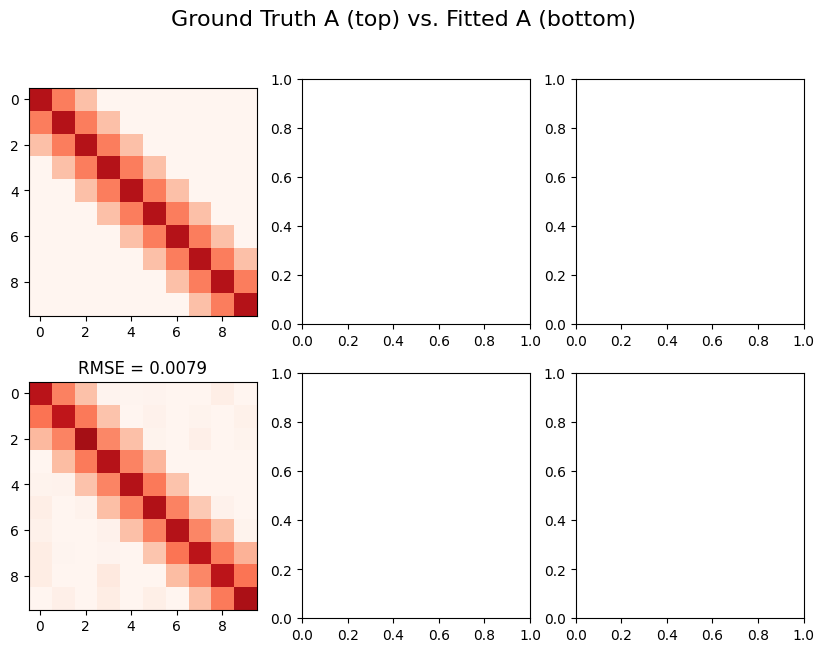

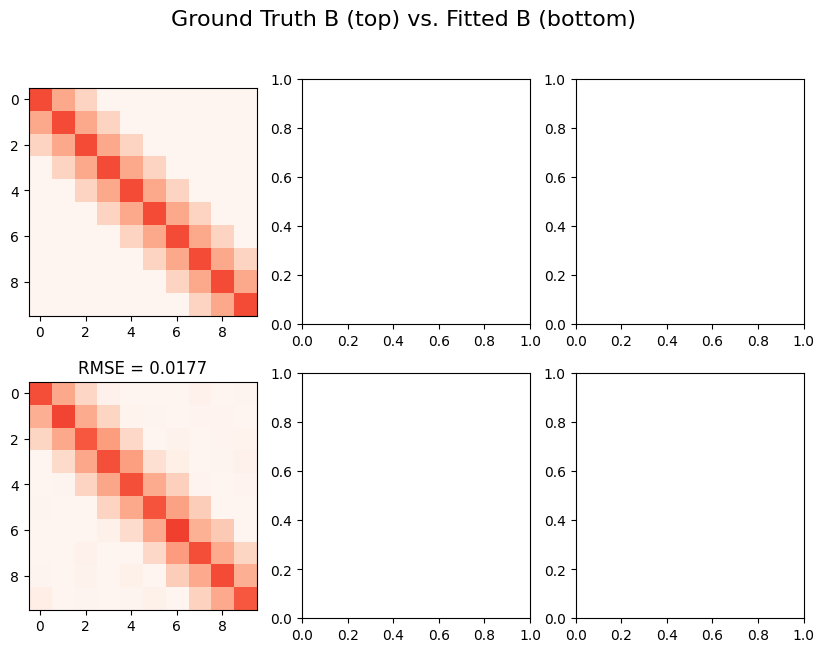

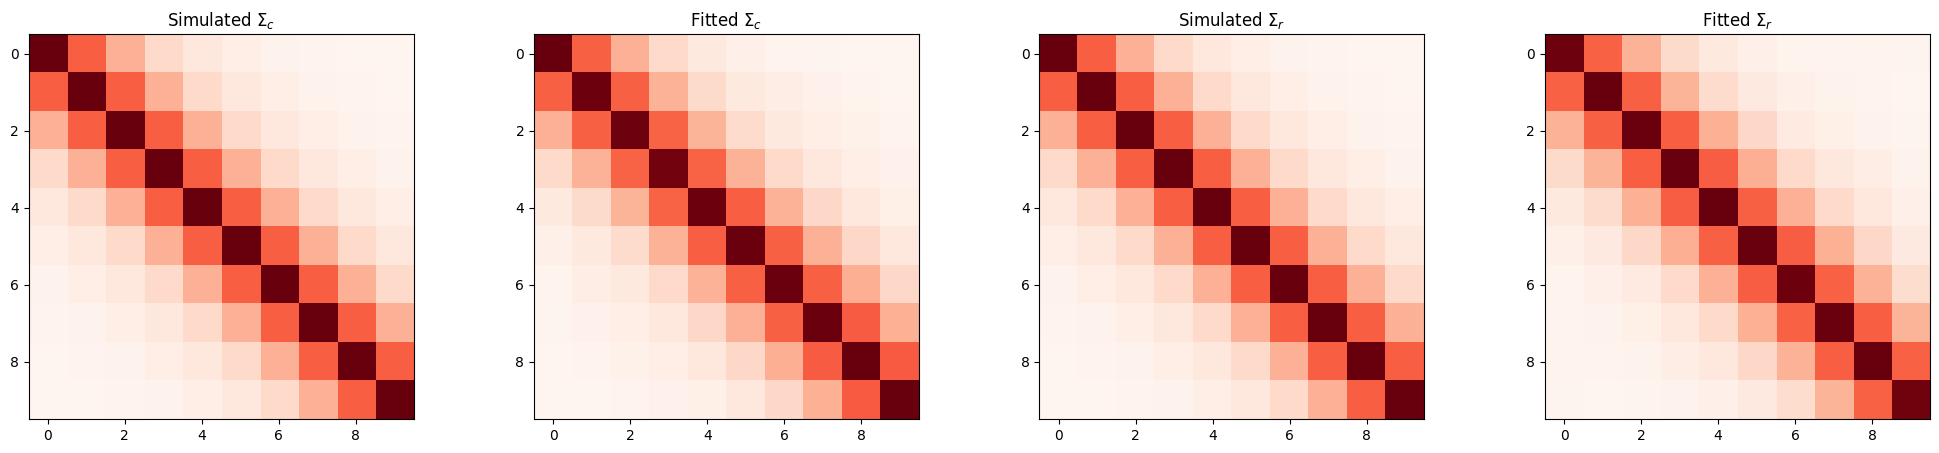

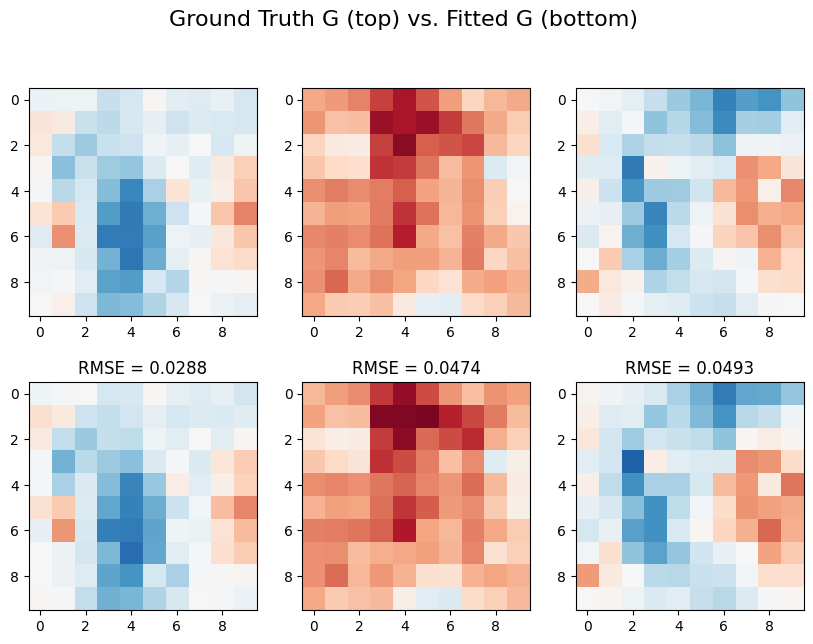

In [15]:
# visualize coefficients
# A
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 7))

for i in range(simP):
    ax[0,i].imshow(AR["A"][i], cmap="Reds", vmin=0.0, vmax=0.3)

for j in range(fitP):
    ax[1,j].imshow(model.params["A"][j], cmap="Reds", vmin=0.0, vmax=0.3)
    ax[1,j].set_title(f"RMSE = {round(np.sqrt(np.mean((model.params['A'][j]-AR['A'][j])**2)), 4)}")

fig.suptitle("Ground Truth A (top) vs. Fitted A (bottom)", fontsize=16);

# B
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 7))

for i in range(simP):
    ax[0,i].imshow(AR["B"][i], cmap="Reds", vmin=0.0, vmax=1.0)

for j in range(fitP):
    ax[1,j].imshow(model.params["B"][j], cmap="Reds", vmin=0.0, vmax=1.0)
    ax[1, j].set_title(f"RMSE = {np.sqrt(np.mean((model.params['B'][j] - AR['B'][j])**2)):.4f}")

fig.suptitle("Ground Truth B (top) vs. Fitted B (bottom)", fontsize=16);

# Sigma
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (25, 5))

ax[0].imshow(ERR["Sigma_c"], cmap="Reds")
ax[1].imshow(model.params["Sigma_c"], cmap="Reds");

ax[2].imshow(ERR["Sigma_r"], cmap="Reds")
ax[3].imshow(model.params["Sigma_r"], cmap="Reds");

ax[0].set_title("Simulated $\Sigma_{c}$");
ax[1].set_title("Fitted $\Sigma_{c}$");

ax[2].set_title("Simulated $\Sigma_{r}$");
ax[3].set_title("Fitted $\Sigma_{r}$");

# G
plotQ = 1

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 7))

for i in range(3):
    ax[0,i].imshow(AC["ground_truth_basis"][plotQ-1,i], cmap="RdBu_r", vmin=-1, vmax=1)
    ax[1,i].imshow(model.params["pattern"][plotQ-1,i], cmap="RdBu_r", vmin=-1, vmax=1)
    ax[1,i].set_title(f"RMSE = {np.sqrt(np.mean((model.params['pattern'][plotQ-1,i] - AC['ground_truth_basis'][plotQ-1,i])**2)):.4f}")

fig.suptitle("Ground Truth G (top) vs. Fitted G (bottom)", fontsize=16);